# TODO
> PICK UP HERE: **implement model end-to-end ASAP using Dataset, saving model state every N epochs, etc.**
- See todo list in OneNote
- Once working, make the saving model state logic generic so I can use with any model

In [1]:
from datatype_recovery.models.dataset import TypeSequenceDataset

data_params = {
    'experiment_runs': [
        '/home/cls0027/test_builds/astera.exp/rundata/run1',
        '/home/cls0027/test_builds/coreutils.exp/rundata/run1',
    ],
    'copy_data': False,
}
dataset = TypeSequenceDataset('model0_dataset', data_params, max_hops=3)
len(dataset)

input_params will be IGNORED in favor of saved .json file (model0_dataset/raw/input_params.json)


44021

In [6]:
# !tar cvzf model0_dataset.tar.gz model0_dataset
!ls -ahl

total 24M
drwxrwxr-x  5 cls0027 cls0027 4.0K Jan  7 18:11 .
drwxrwxr-x  6 cls0027 cls0027 4.0K Sep 27 09:13 ..
-rw-rw-r--  1 cls0027 cls0027  49K Dec 27 21:25 ast_sandbox.ipynb
-rw-rw-r--  1 cls0027 cls0027 278K Oct  5 08:28 characterize_dataset.html
-rw-rw-r--  1 cls0027 cls0027  41K Dec 20 19:39 characterize_dataset.ipynb
-rw-rw-r--  1 cls0027 cls0027  38K Oct 24 08:44 characterize_dataset.pdf
-rw-rw-r--  1 cls0027 cls0027 9.4K Dec 27 20:41 data_0.pt
-rw-rw-r--  1 cls0027 cls0027  42K Dec 27 15:43 data_group_0.pt
-rw-rw-r--  1 cls0027 cls0027  44K Dec 21 18:20 graph_classification_model.pt
drwxrwxr-x  4 cls0027 cls0027 4.0K Jan  3 17:52 model0_dataset
-rw-rw-r--  1 cls0027 cls0027  16M Jan  7 18:11 model0_dataset.tar.gz
-rw-rw-r--  1 cls0027 cls0027  50K Jan  3 22:20 model0.ipynb
-rw-rw-r--  1 cls0027 cls0027  11K Dec 21 10:45 __old_pyg_sandbox.ipynb
-rw-rw-r--  1 cls0027 cls0027 7.1M Dec 21 18:34 paths_and_labels.tsv
-rw-rw-r--  1 cls0027 cls0027  46K Dec 21 20:46 pyg_dataset_sandbo

In [32]:
import pandas as pd
df = pd.read_csv('/home/cls0027/test_builds/coreutils.exp/rundata/run1/locals.csv')
df.loc[:,'TypeSeqLen_Debug'] = [len(x.split(',')) for x in df.TypeSeq_Debug]
df.TypeSeqLen_Debug.describe()

count    11585.000000
mean         1.397497
std          0.534427
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: TypeSeqLen_Debug, dtype: float64

<Axes: xlabel='TypeSeqLen_Debug'>

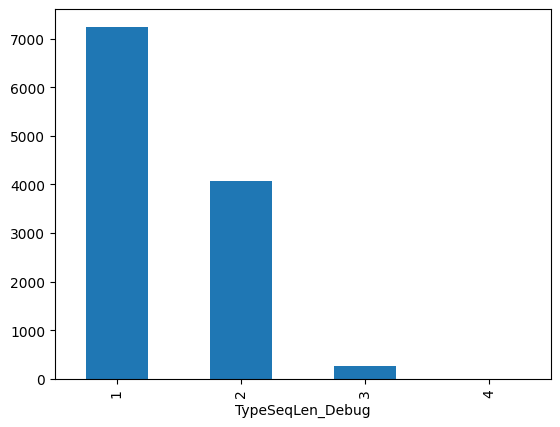

In [33]:
df.groupby('TypeSeqLen_Debug').count().TypeSeq_Debug.plot(kind='bar')

In [35]:
df[df.TypeSeqLen_Debug==4]

,FunctionStart,Name_Debug,Signature,Type_Debug,LocType_Debug,LocRegName_Debug,LocOffset_Debug,TypeCategory_Debug,TypeSeq_Debug,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,BinaryId,TypeSeqLen_Debug
1262,1069103,all_line,"268,752,1798,1937,2018,2103,2166",linebuffer*[4][2],stack,NaN,-408,ARRAY,"ARR,ARR,PTR,STRUCT",alStack_198,int64_t[8],stack,NaN,-408,ARRAY,"ARR,int64_t",18,4


# Poor man's LSTM?
I think we can do LSTM just fine, but going back to the original question I had...

> How long is the max type sequence in our dataset?
> What is the average size?

And based on those answers...

> **What if we (at least start with) implement a fixed-length output vector representing the sequence?**
`[t1 vec | t2 vec | t3 vec ... tN vec]`

- It avoids the LSTM complication (which isn't too bad, but what if it doesn't perform well? Then we open
the can of worms into attention, Transformer, etc.).
- **Sequence decoder is totally fine if/when we need it!** But what if we only *ever* have up to 3 levels? Maybe overkill?

# TODO LIST
1. Dataset: make the tensor's floats that needed to be floats
2. Pandas: what is the max/min/avg type sequence length?
    - Coreutils?
    - Astera?
    - Others?
3. (Based on that answer) **Is it worth trying a fixed-length output vector or not?**

In [2]:
# TODO: split test/train on BINARY boundary to prevent functions/vars from crossing
# -> I have varid tuples, so I can get (rungid, binid) from that and use it to split
#   - extract (idx, rungid, binid) for each data point and put into a dataframe
#   - groupby/count dataframe by (rungid/binid) and come up with split that is close to target %
#   - collect indices for each data point within each subset (test/train/valid)
#   - quick/simple validate that all (rungid/binid) combos are unique to a subset
#
# [(i, x.varid[0], x.varid[1]) for i, x in enumerate(dataset[10000:10100])][:5]

# trainset_indices = list(range(12))
# testset_indices = list(range(100,112))
# train_set = Subset(dataset, trainset_indices)
# test_set = Subset(dataset, testset_indices)

import torch
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset

# model
HIDDEN_CHANNELS = 128

# training
BATCH_SIZE = 64
TRAIN_SPLIT = 0.7
NUM_EPOCHS = 1500
SHUFFLE = True
PIN_MEMORY=False

# optimizer
LEARN_RATE = 0.001

torch.manual_seed(33)   # deterministic hopefully? lol

dataset = dataset[:1024]    # TEMP: take small subset

# divide into train/test sets
train_size = int(len(dataset)*TRAIN_SPLIT)
train_size -= train_size%BATCH_SIZE     # align to batch size

test_size = len(dataset) - train_size   # take the rest of the dataset...
test_size -= test_size % BATCH_SIZE     # align to batch size

train_set = Subset(dataset, range(0, 0+train_size))
test_set = Subset(dataset, range(len(train_set), len(train_set)+test_size))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE, pin_memory=PIN_MEMORY)

# EXAMPLE: the shuffled slice changes each time, but dataset[0] stays consistent
# print(dataset[:10].shuffle()[0].varid)
# print(dataset[0].varid)
total_usable = len(train_set)+len(test_set)
non_batch_aligned = len(dataset)-total_usable
print(f'Train set: {len(train_set):,} samples ({len(train_set)/len(dataset)*100:.2f}%)')
print(f'Test set: {len(test_set):,} samples ({len(test_set)/len(dataset)*100:.2f}%)')
print(f'Batch size: {BATCH_SIZE}')
print(f'Total usable dataset size (batch-aligned): {total_usable:,}')
print(f'Loss due to batch alignment: {non_batch_aligned:,} ({non_batch_aligned/len(dataset)*100:.2f}%)')

Train set: 704 samples (68.75%)
Test set: 320 samples (31.25%)
Batch size: 64
Total usable dataset size (batch-aligned): 1,024
Loss due to batch alignment: 0 (0.00%)


,Train,Test,TrainPcnt,TestPcnt
Label,,,,
ARR,46,13,6.534091,4.0625
ENUM,1,1,0.142045,0.3125
PTR,151,77,21.448864,24.0625
STRUCT,16,6,2.272727,1.8750
UNION,4,3,0.568182,0.9375
double,11,8,1.562500,2.5000
float,25,12,3.551136,3.7500
int32_t,321,142,45.596591,44.3750
int64_t,10,4,1.420455,1.2500


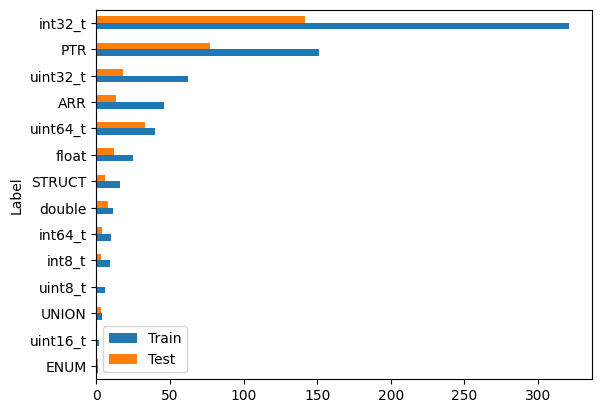

In [3]:
from datatype_recovery.models.dataset.encoding import decode_typeseq
import pandas as pd

train_df = pd.DataFrame({
    'Label': [decode_typeseq(sample.y)[0] for sample in train_set],
    'Varid': [sample.varid for sample in train_set],
    'Split': ['Train']*len(train_set),
    'Train': [True]*len(train_set),
})

test_df = pd.DataFrame({
    'Label': [decode_typeseq(sample.y)[0] for sample in test_set],
    'Varid': [sample.varid for sample in test_set],
    'Split': ['Test']*len(test_set),
    'Test': [True]*len(test_set),
})

df = pd.concat([train_df, test_df])
# gdf = train_df.groupby('Label').count().sort_values('Varid')
# gdf.loc[:,'Percent'] = gdf.Varid/len(train_df)*100
# gdf

df.groupby(['Label'])[['Train','Test']].count().sort_values('Train') \
    .plot(kind='barh')

dataset_classes = df.groupby(['Label'])[['Train','Test']].count()
dataset_classes.loc[:,'TrainPcnt'] = dataset_classes.Train/dataset_classes.Train.sum()*100
dataset_classes.loc[:,'TestPcnt'] = dataset_classes.Test/dataset_classes.Test.sum()*100
# dataset_classes.sum()
dataset_classes

# Model Definition

In [4]:
import torch
from torch.nn import functional as F
from torch_geometric.data import Dataset
from torch_geometric.nn import GATConv, Linear
from typing import List

def split_node_index_by_graph(batch:torch.tensor, batch_size:int) -> List[torch.tensor]:
    '''
    Returns the node_index for each individual graph within the batch as a list of tensors.

    Each list entry (node_index) is a tensor of node indices for an individual graph within the
    batch, where each of the node indices will index into the containing DataBatch.x.
    '''
    return [(batch==i).nonzero(as_tuple=True) for i in range(batch_size)]

def get_node0_indices(batch:torch.tensor) -> List[int]:
    '''
    Returns the indices of all "node 0" nodes in the batch
    '''
    batch_size = batch.max().item()+1
    node_index_by_graph = split_node_index_by_graph(batch, batch_size)
    return [x[0][0].item() for x in node_index_by_graph]


class TypeSeqModel(torch.nn.Module):
    def __init__(self, dataset:Dataset, hidden_channels:int):
        super(TypeSeqModel, self).__init__()

        # if we go with fewer layers than the # hops in our dataset
        # that may be fine for experimenting, but eventually we are wasting
        # time/space and can cut our dataset down to match (# hops = # layers)
        self.gat1 = GATConv(dataset.num_node_features, hidden_channels)
        self.gat2 = GATConv(hidden_channels, hidden_channels)
        self.gat3 = GATConv(hidden_channels, hidden_channels)

        # TODO - later on, add sequential layer(s) here

        self.pred_head = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        node0_indices = get_node0_indices(batch)

        # FIXME: if we need floats in the dataset, go back and save the data
        # this way in our Dataset class
        x = x.to(torch.float32)

        # GNN layers
        # ----------
        # NOTE: it's tempting to downselect to node0 indices here, but I think
        # that may be incorrect - we would not be passing ALL NODES through the
        # network, just node 0.

        # I think we WANT to compute the network on every node
        # for N hops and then simply make predictions based on the node 0 nodes
        #
        # yeah...if we did not compute this on ALL nodes, I think we are
        # making it effectively 1 hop only, and just going multiple rounds with 1 hop!

        h = self.gat1(x, edge_index)
        h = h.relu()

        h = self.gat2(h, edge_index)
        h = h.relu()

        h = self.gat3(h, edge_index)
        # relu here?

        logits = self.pred_head(h[node0_indices])
        return logits


In [5]:
model = TypeSeqModel(dataset, hidden_channels=HIDDEN_CHANNELS)
print(model)

TypeSeqModel(
  (gat1): GATConv(47, 128, heads=1)
  (gat2): GATConv(128, 128, heads=1)
  (gat3): GATConv(128, 128, heads=1)
  (pred_head): Linear(128, 20, bias=True)
)


In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
criterion = torch.nn.CrossEntropyLoss()

def train_one_epoch(train_loader:DataLoader, dev):
    model.train()

    for data in train_loader:
        data.to(dev)
        out = model(data.x, data.edge_index, data.batch)
        # FIXME: change this to floats in Dataset if we need to stick with this
        loss = criterion(out, data.y.to(torch.float32))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def eval(loader:DataLoader, dev):
    model.eval()

    correct = 0
    total_loss = 0
    for data in loader:
        data.to(dev)
        out = model(data.x, data.edge_index, data.batch)
        # FIXME: change this to floats in Dataset if we need to stick with this
        loss = criterion(out, data.y.to(torch.float32))
        total_loss += loss.item()
        pred_probabilities = F.softmax(out, dim=1)
        correct += int((pred_probabilities.argmax(dim=1) == data.y.argmax(dim=1)).sum())
    return correct/len(loader.dataset), total_loss/len(loader.dataset)

In [7]:
import torch

if not torch.cuda.is_available():
    print(f'CUDA NOT AVAILABLE!')
else:
    print(f'Device count: {torch.cuda.device_count()}')
    for i in range(torch.cuda.device_count()):
        print(f'Device {i}: {torch.cuda.get_device_name(i)}')

CUDA_DEVICE = 0

Device count: 4
Device 0: Tesla M10
Device 1: Tesla M10
Device 2: Tesla M10
Device 3: Tesla M10


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cstew33 (uah-phd). Use `wandb login --relogin` to force relogin


---------------
Current device: cuda:0
Current CUDA device: 0 (Tesla M10)
Train loss = 0.0468, train accuracy = 1.42%
Test loss = 0.0467, test accuracy = 1.25%


  0%|          | 0/1499 [00:00<?, ?it/s]

Train loss = 0.0009, train accuracy = 97.16%
Test loss = 0.0009, test accuracy = 96.56%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test/acc,▁▃▄▅▅▆▆▆▇▇▇▇▇▇████▇▇█▇██████████████████
test/loss,█▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▄▄▅▆▆▇▇▇▇▇▇█████▇█▇█▇██████████████████
train/loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/acc,0.96562
test/loss,0.00093
train/acc,0.97159
train/loss,0.00088


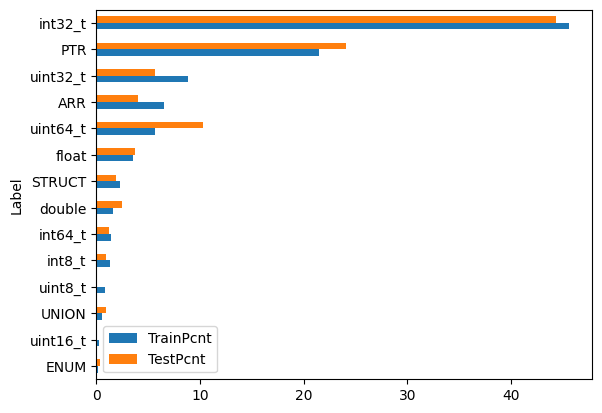

In [8]:
from tqdm.auto import trange

# 2m, 13.7s to get initial train/test accuracy on CPU
# ~3m to get initial " on GPU
# 7m and counting without finishing first epoch using individual .to() methods...

import wandb
wandb.login()

from pathlib import Path
dataset_names = ','.join([Path(x).parent.parent.stem for x in data_params['experiment_runs']])

wandb.init(
    # set the wandb project where this run will be logged
    project="model0",

    # track hyperparameters and run metadata
    config={
        "learning_rate": LEARN_RATE,
        "architecture": "GATConv",
        "dataset": dataset_names,
        "epochs": NUM_EPOCHS,
        'hidden_channels': HIDDEN_CHANNELS,
    }
)

wandb.log({
    'Dataset/classes': wandb.Table(dataframe=dataset_classes \
                        .sort_values('Train',ascending=False) \
                        .reset_index()),
    'Dataset/plot': wandb.Image(
        dataset_classes[['TrainPcnt','TestPcnt']].sort_values('TrainPcnt').plot(kind='barh')
    ),
})

with torch.cuda.device(CUDA_DEVICE):
    cuda_dev = torch.cuda.current_device()
    device = f'cuda:{cuda_dev}' if torch.cuda.is_available() else 'cpu'
    print(f'---------------')
    print(f'Current device: {device}')
    print(f'Current CUDA device: {cuda_dev} ({torch.cuda.get_device_name(cuda_dev)})')

    # move model to device
    model = model.to(device)

    train_acc, train_loss = eval(train_loader, device)
    test_acc, test_loss = eval(test_loader, device)
    print(f'Train loss = {train_loss:.4f}, train accuracy = {train_acc*100:,.2f}%')
    print(f'Test loss = {test_loss:.4f}, test accuracy = {test_acc*100:,.2f}%')

    for epoch in trange(1, NUM_EPOCHS):
        train_one_epoch(train_loader, device)
        train_acc, train_loss = eval(train_loader, device)
        test_acc, test_loss = eval(test_loader, device)
        wandb.log({
            'train/loss': train_loss,
            'train/acc': train_acc,
            'test/loss': test_loss,
            'test/acc': test_acc,
        })
        torch.save(model, 'type_seq_model.pt')

    train_acc, train_loss = eval(train_loader, device)
    test_acc, test_loss = eval(test_loader, device)
    print(f'Train loss = {train_loss:.4f}, train accuracy = {train_acc*100:,.2f}%')
    print(f'Test loss = {test_loss:.4f}, test accuracy = {test_acc*100:,.2f}%')
    wandb.finish()

In [9]:
# for i in range(b.x.shape[0]):
#     print(decode_astnode(b.x[i]))

In [10]:
# rungid, bid, _, _, _ = dataset[0].varid
# [(x.varid[0], x.varid[1]) for x in dataset[10000:10100]][:5]

In [11]:
[(i, x.varid[0], x.varid[1]) for i, x in enumerate(dataset[10000:10100])][:5]

indices = [10000, 10001, 10002, 10003, 10004]
from torch.utils.data import Subset

ss = Subset(dataset, indices)
loader = DataLoader(ss, shuffle=True)
[(x.varid[0][0], x.varid[0][1]) for x in loader]

IndexError: range object index out of range